<h1> Big Data

<h2> Group 5

<h4> Create a spark session and load the Incident Management Data set

In [0]:
from pyspark.sql import SparkSession


In [0]:
spark = SparkSession.builder.appName('Desicion-Tree').getOrCreate()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn


In [0]:
# File Upload for all the models

file_location = "/FileStore/tables/airbnb.csv"
file_type = "csv"
 
# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
 
#Use spark to ingest the dataset and create a DataFrame
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
data = df

In [0]:
#Remove null values from dataframe and replace frame object
data=data.dropna() 
origNumColumns = len(df.columns)

In [0]:
df.printSchema()

root
 |-- host_is_superhost: integer (nullable = true)
 |-- host_identity_verified: integer (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- Number_of_amenities: integer (nullable = true)
 |-- guests_included: integer (nullable = true)
 |-- price_per_extra_person: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- number_days_btw_first_last_review: integer (nullable = true)
 |-- review_scores_rating: integer (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- 

<h3>Data Preparation and Transformation

In [0]:
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline

In [0]:
# Use StringIndexer to convert the categorical columns to hold numerical data - PySpark modeling required all categorical data be numerical 
 
neighbourhood_cleansed_indexer = StringIndexer(inputCol='neighbourhood_cleansed',outputCol='neighbourhood_cleansed_index',handleInvalid='keep')
property_type_indexer = StringIndexer(inputCol='property_type',outputCol='property_type_index',handleInvalid='keep')
room_type_indexer = StringIndexer(inputCol='room_type',outputCol='room_type_index',handleInvalid='keep')
bed_type_indexer = StringIndexer(inputCol='bed_type',outputCol='bed_type_index',handleInvalid='keep')
cancellation_policy_group_indexer = StringIndexer(inputCol='cancellation_policy',outputCol='cancellation_policy_index',handleInvalid='keep')


In [0]:
# Vector assembler is used to merge multiple input columns into an output vector column named 'features', note we are using the indexed columns created by the StringIndexer calls previously
 
assembler = VectorAssembler(inputCols=['neighbourhood_cleansed_index',
                                       'property_type_index','room_type_index','bed_type_index','cancellation_policy_index',
                                       'price_category_index','host_is_superhost','host_identity_verified','latitude','longitude','accommodates','bathrooms',
                                       'bedrooms','beds','Number_of_amenities','guests_included','price_per_extra_person',
                                       'minimum_nights','number_of_reviews','number_days_btw_first_last_review',
                                       'review_scores_rating','price','price_gte_150'],
                            outputCol="features")


In [0]:
# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-process the test data
# in the same way as that of the train data.
 
pipe = Pipeline(stages=[neighbourhood_cleansed_indexer,property_type_indexer,room_type_indexer,bed_type_indexer,cancellation_policy_group_indexer,price_category_indexer, assembler])

In [0]:
#"Fit the data to the model": Spark uses machine learning algorithms called "Estimators" to create Model objects that will perform the transformation.  Estimators implement the 'fit' method to create Models. The StringIndexers are Estimators and implement fit().
learned_data = pipe.fit(data)

#Run the transformation using the Models created by the Estimators.  Models implement the 'transform' method to do their work.  Here the StringIndexer columns are appended to the dataframe.  The VectorAssembler is a Model and implements transform(), and does its work combining the columns we configured in its construction into the vector output column 'features' - note it must be last in the list of pipeline stages for this reason.
final_data = learned_data.transform(data)


In [0]:
#View data using Databricks function
display(final_data)

host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,Number_of_amenities,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category,neighbourhood_cleansed_index,property_type_index,room_type_index,bed_type_index,cancellation_policy_index,price_category_index,features
0,1,Roslindale,42.28624082,-71.13437396,Apartment,Private room,2,1.0,1,1,Real Bed,20,0,0,2,36,804,94,moderate,65,0,lte_$75,16.0,0.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 42.28624082, -71.13437396, 2.0, 1.0, 1.0, 1.0, 20.0, 0.0, 0.0, 2.0, 36.0, 804.0, 94.0, 65.0, 0.0))"
1,1,Roslindale,42.29243789,-71.13576525,Apartment,Private room,2,1.0,1,1,Real Bed,17,1,20,3,41,2574,98,moderate,65,0,lte_$75,16.0,0.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.29243789, -71.13576525, 2.0, 1.0, 1.0, 1.0, 17.0, 1.0, 20.0, 3.0, 41.0, 2574.0, 98.0, 65.0, 0.0))"
0,0,Roslindale,42.28110619,-71.12102117,House,Private room,4,1.0,1,2,Real Bed,22,2,25,1,1,0,100,moderate,75,0,lte_$75,16.0,1.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 42.28110619, -71.12102117, 4.0, 1.0, 1.0, 2.0, 22.0, 2.0, 25.0, 1.0, 1.0, 0.0, 100.0, 75.0, 0.0))"
1,1,Roslindale,42.28451221,-71.13625805,House,Private room,2,1.5,1,2,Real Bed,13,1,0,2,29,380,99,flexible,79,0,btw_$75-$150,16.0,1.0,1.0,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 42.28451221, -71.13625805, 2.0, 1.5, 1.0, 2.0, 13.0, 1.0, 0.0, 2.0, 29.0, 380.0, 99.0, 79.0, 0.0))"
1,1,Roslindale,42.2916898,-71.13189277,Condominium,Private room,2,1.0,1,1,Real Bed,12,1,0,2,8,130,100,flexible,75,0,lte_$75,16.0,2.0,1.0,0.0,2.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 2.0, 1.0, 0.0, 2.0, 3.0, 1.0, 1.0, 42.2916898, -71.13189277, 2.0, 1.0, 1.0, 1.0, 12.0, 1.0, 0.0, 2.0, 8.0, 130.0, 100.0, 75.0, 0.0))"
0,1,Roslindale,42.28138963,-71.13119042,Apartment,Entire home/apt,3,1.0,1,2,Real Bed,12,1,25,1,57,421,90,strict,100,0,btw_$75-$150,16.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 42.28138963, -71.13119042, 3.0, 1.0, 1.0, 2.0, 12.0, 1.0, 25.0, 1.0, 57.0, 421.0, 90.0, 100.0, 0.0))"
1,1,Roslindale,42.2819461,-71.14102161,House,Private room,2,2.0,1,1,Real Bed,22,1,15,1,67,840,96,moderate,75,0,lte_$75,16.0,1.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.2819461, -71.14102161, 2.0, 2.0, 1.0, 1.0, 22.0, 1.0, 15.0, 1.0, 67.0, 840.0, 96.0, 75.0, 0.0))"
1,1,Roslindale,42.28587764,-71.12490956,Condominium,Private room,2,1.0,1,2,Real Bed,9,2,0,2,65,355,96,moderate,58,0,lte_$75,16.0,2.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 2.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.28587764, -71.12490956, 2.0, 1.0, 1.0, 2.0, 9.0, 2.0, 0.0, 2.0, 65.0, 355.0, 96.0, 58.0, 0.0))"
1,1,Roslindale,42.28882028,-71.1395101,Apartment,Entire home/apt,5,1.0,2,2,Real Bed,21,4,25,4,33,876,94,strict,229,1,gte_226,16.0,0.0,0.0,0.0,0.0,2.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 42.28882028, -71.1395101, 5.0, 1.0, 2.0, 2.0, 21.0, 4.0, 25.0, 4.0, 33.0, 876.0, 94.0, 229.0, 1.0))"
0,0,Roslindale,42.2864482,-71.13932539,House,Private room,2,1.0,1,1,Real Bed,15,1,10,1,1,0,80,flexible,60,0,lte_$75,16.0,1.0,1.0,0.0,2.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 2.0, 3.0, 0.0, 0.0, 42.2864482, -71.13932539, 2.0, 1.0, 1.0, 1.0, 15.0, 1.0, 10.0, 1.0, 1.0, 0.0, 80.0, 60.0, 0.0))"


<h3>Building the K Means model

<h3> Determine number of clusters.

In [0]:

from pyspark.ml.clustering import KMeans

In [0]:
errors=[]

for k in range(2,10):
    #Will use our Vector 'features' column prepared in previous steps
    kmeans = KMeans(featuresCol='features',k=k)
    #Train the KMeans model on the data ('fitting the model'), whereby the Estimator creates the Model object
    model = kmeans.fit(final_data)
    intra_distance = model.summary.trainingCost
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 196002815.83461052
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 112589008.82705025
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 70515753.87717594
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 61725896.66569135
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 46705045.03176053
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 41737849.22853175
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 37187882.76173363
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 34728595.444270715
------------------------------------------------------------


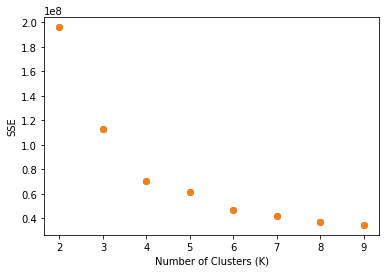

In [0]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number,errors)
plt.show()

<h3> Number of cluster selection

In [0]:
#Based on the above distribution, choose a K value
kmeans_model = KMeans(k=5)

In [0]:
#Train the model on the data
fit_model = kmeans_model.fit(final_data)

In [0]:
wssse = fit_model.summary.trainingCost # for spark 3.0
print("The within set sum of squared error of the mode is {}".format(wssse))


The within set sum of squared error of the mode is 61725896.66569135


In [0]:
centers = fit_model.clusterCenters()

In [0]:
print("Cluster Centers")
index=1
for cluster in centers:
    print("Centroid {}: {}".format(index,cluster))
    index+=1

Cluster Centers
Centroid 1: [ 6.73673257e+00  5.40062435e-01  6.28511967e-01  1.36316337e-01
  1.00832466e+00  1.18418314e+00  8.01248699e-02  6.68054110e-01
  4.23369474e+01 -7.10888253e+01  2.34755463e+00  1.14412071e+00
  9.98959417e-01  1.29136316e+00  1.40457856e+01  1.20707596e+00
  9.72112383e+00  2.92715921e+00  7.63683663e+00  6.53891779e+01
  9.10874089e+01  1.02454735e+02  2.15400624e-01]
Centroid 2: [ 6.54260090e+00  5.44843049e-01  4.28251121e-01  6.72645740e-02
  7.30941704e-01  1.21748879e+00  2.62331839e-01  8.56502242e-01
  4.23349298e+01 -7.10854649e+01  3.06950673e+00  1.21300448e+00
  1.23542601e+00  1.66143498e+00  1.52600897e+01  1.63452915e+00
  1.48654709e+01  3.27354260e+00  5.83049327e+01  8.67219731e+02
  9.21434978e+01  1.67565022e+02  4.70852018e-01]
Centroid 3: [ 6.34905660e+00  5.75471698e-01  3.67924528e-01  7.54716981e-02
  7.83018868e-01  1.47169811e+00  1.13207547e-01  7.73584906e-01
  4.23378018e+01 -7.10811310e+01  3.60377358e+00  1.18867925e+00
  1

In [0]:
#Use Model to transform data, this will add a predicted cluster column to the data frame for each row
results = fit_model.transform(final_data)

In [0]:
display(results)

host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,Number_of_amenities,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category,neighbourhood_cleansed_index,property_type_index,room_type_index,bed_type_index,cancellation_policy_index,price_category_index,features,prediction
0,1,Roslindale,42.28624082,-71.13437396,Apartment,Private room,2,1.0,1,1,Real Bed,20,0,0,2,36,804,94,moderate,65,0,lte_$75,16.0,0.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 42.28624082, -71.13437396, 2.0, 1.0, 1.0, 1.0, 20.0, 0.0, 0.0, 2.0, 36.0, 804.0, 94.0, 65.0, 0.0))",1
1,1,Roslindale,42.29243789,-71.13576525,Apartment,Private room,2,1.0,1,1,Real Bed,17,1,20,3,41,2574,98,moderate,65,0,lte_$75,16.0,0.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.29243789, -71.13576525, 2.0, 1.0, 1.0, 1.0, 17.0, 1.0, 20.0, 3.0, 41.0, 2574.0, 98.0, 65.0, 0.0))",2
0,0,Roslindale,42.28110619,-71.12102117,House,Private room,4,1.0,1,2,Real Bed,22,2,25,1,1,0,100,moderate,75,0,lte_$75,16.0,1.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 42.28110619, -71.12102117, 4.0, 1.0, 1.0, 2.0, 22.0, 2.0, 25.0, 1.0, 1.0, 0.0, 100.0, 75.0, 0.0))",0
1,1,Roslindale,42.28451221,-71.13625805,House,Private room,2,1.5,1,2,Real Bed,13,1,0,2,29,380,99,flexible,79,0,btw_$75-$150,16.0,1.0,1.0,0.0,2.0,0.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 42.28451221, -71.13625805, 2.0, 1.5, 1.0, 2.0, 13.0, 1.0, 0.0, 2.0, 29.0, 380.0, 99.0, 79.0, 0.0))",3
1,1,Roslindale,42.2916898,-71.13189277,Condominium,Private room,2,1.0,1,1,Real Bed,12,1,0,2,8,130,100,flexible,75,0,lte_$75,16.0,2.0,1.0,0.0,2.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 2.0, 1.0, 0.0, 2.0, 3.0, 1.0, 1.0, 42.2916898, -71.13189277, 2.0, 1.0, 1.0, 1.0, 12.0, 1.0, 0.0, 2.0, 8.0, 130.0, 100.0, 75.0, 0.0))",0
0,1,Roslindale,42.28138963,-71.13119042,Apartment,Entire home/apt,3,1.0,1,2,Real Bed,12,1,25,1,57,421,90,strict,100,0,btw_$75-$150,16.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 42.28138963, -71.13119042, 3.0, 1.0, 1.0, 2.0, 12.0, 1.0, 25.0, 1.0, 57.0, 421.0, 90.0, 100.0, 0.0))",3
1,1,Roslindale,42.2819461,-71.14102161,House,Private room,2,2.0,1,1,Real Bed,22,1,15,1,67,840,96,moderate,75,0,lte_$75,16.0,1.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.2819461, -71.14102161, 2.0, 2.0, 1.0, 1.0, 22.0, 1.0, 15.0, 1.0, 67.0, 840.0, 96.0, 75.0, 0.0))",1
1,1,Roslindale,42.28587764,-71.12490956,Condominium,Private room,2,1.0,1,2,Real Bed,9,2,0,2,65,355,96,moderate,58,0,lte_$75,16.0,2.0,1.0,0.0,1.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 2.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 42.28587764, -71.12490956, 2.0, 1.0, 1.0, 2.0, 9.0, 2.0, 0.0, 2.0, 65.0, 355.0, 96.0, 58.0, 0.0))",3
1,1,Roslindale,42.28882028,-71.1395101,Apartment,Entire home/apt,5,1.0,2,2,Real Bed,21,4,25,4,33,876,94,strict,229,1,gte_226,16.0,0.0,0.0,0.0,0.0,2.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 42.28882028, -71.1395101, 5.0, 1.0, 2.0, 2.0, 21.0, 4.0, 25.0, 4.0, 33.0, 876.0, 94.0, 229.0, 1.0))",1
0,0,Roslindale,42.2864482,-71.13932539,House,Private room,2,1.0,1,1,Real Bed,15,1,10,1,1,0,80,flexible,60,0,lte_$75,16.0,1.0,1.0,0.0,2.0,3.0,"Map(vectorType -> dense, length -> 23, values -> List(16.0, 1.0, 1.0, 0.0, 2.0, 3.0, 0.0, 0.0, 42.2864482, -71.13932539, 2.0, 1.0, 1.0, 1.0, 15.0, 1.0, 10.0, 1.0, 1.0, 0.0, 80.0, 60.0, 0.0))",0


<h3> Cluster Summary

In [0]:
display(results.groupby('prediction').count().sort('prediction'))

prediction,count
0,961
1,446
2,106
3,733
4,486


<h3> Cluster Graph

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

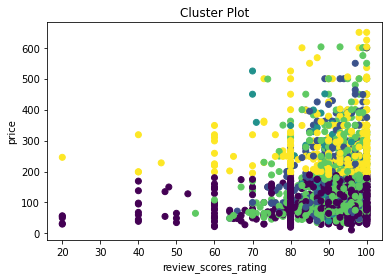

In [0]:
#Get the original dataframe columns plus the cluster predictions generated by the model (leave out the indexed and vector columns)
predictions = results.select(['host_is_superhost','host_identity_verified','neighbourhood_cleansed',
                                       'property_type','room_type','bed_type','cancellation_policy',
                                       'price_category','latitude','longitude','accommodates','bathrooms',
                                       'bedrooms','beds','Number_of_amenities','guests_included','price_per_extra_person',
                                       'minimum_nights','number_of_reviews','number_days_btw_first_last_review',
                                       'review_scores_rating','price','price_gte_150', 'prediction'])

# convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = predictions.toPandas()

# plot clusters
plt.scatter(pandas_df['review_scores_rating'], pandas_df['price'], c=pandas_df['prediction'])
plt.title("Cluster Plot")
plt.xlabel("review_scores_rating")
plt.ylabel("price")
plt.show()

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
pandas_df = predictions.toPandas()
display(pandas_df)

host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bed_type,cancellation_policy,price_category,latitude,longitude,accommodates,bathrooms,bedrooms,beds,Number_of_amenities,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,price,price_gte_150,prediction
0,1,Roslindale,Apartment,Private room,Real Bed,moderate,lte_$75,42.28624082,-71.13437396,2,1.0,1,1,20,0,0,2,36,804,94,65,0,1
1,1,Roslindale,Apartment,Private room,Real Bed,moderate,lte_$75,42.29243789,-71.13576525,2,1.0,1,1,17,1,20,3,41,2574,98,65,0,2
0,0,Roslindale,House,Private room,Real Bed,moderate,lte_$75,42.28110619,-71.12102117,4,1.0,1,2,22,2,25,1,1,0,100,75,0,0
1,1,Roslindale,House,Private room,Real Bed,flexible,btw_$75-$150,42.28451221,-71.13625805,2,1.5,1,2,13,1,0,2,29,380,99,79,0,3
1,1,Roslindale,Condominium,Private room,Real Bed,flexible,lte_$75,42.2916898,-71.13189277,2,1.0,1,1,12,1,0,2,8,130,100,75,0,0
0,1,Roslindale,Apartment,Entire home/apt,Real Bed,strict,btw_$75-$150,42.28138963,-71.13119042,3,1.0,1,2,12,1,25,1,57,421,90,100,0,3
1,1,Roslindale,House,Private room,Real Bed,moderate,lte_$75,42.2819461,-71.14102161,2,2.0,1,1,22,1,15,1,67,840,96,75,0,1
1,1,Roslindale,Condominium,Private room,Real Bed,moderate,lte_$75,42.28587764,-71.12490956,2,1.0,1,2,9,2,0,2,65,355,96,58,0,3
1,1,Roslindale,Apartment,Entire home/apt,Real Bed,strict,gte_226,42.28882028,-71.1395101,5,1.0,2,2,21,4,25,4,33,876,94,229,1,1
0,0,Roslindale,House,Private room,Real Bed,flexible,lte_$75,42.2864482,-71.13932539,2,1.0,1,1,15,1,10,1,1,0,80,60,0,0


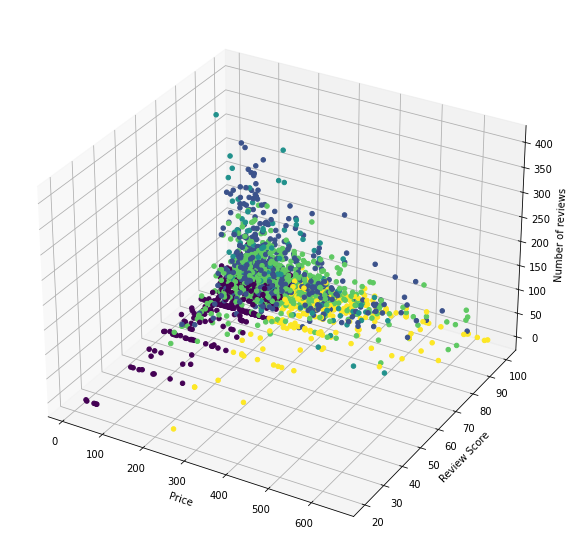

In [0]:
cluster_vis = plt.figure(figsize=(15,10)).add_subplot(projection='3d')
cluster_vis.scatter(pandas_df.price, pandas_df.review_scores_rating, pandas_df.number_of_reviews, c=pandas_df.prediction,depthshade=False)
cluster_vis.set_xlabel('Price')
cluster_vis.set_ylabel('Review Score')
cluster_vis.set_zlabel('Number of reviews')
plt.show()